## Initial Report: Startup Success Prediction

### Overview

This project aims to analyze factors contributing to startup success using the available dataset. By conducting Exploratory Data Analysis (EDA), we seek to uncover patterns, relationships, and insights that will serve as the foundation for predictive modeling.

Startups are a dynamic and pivotal sector in economic growth, yet they face significant risks and uncertainties. Understanding the attributes associated with startup success—defined as achieving an acquisition or IPO—can help investors, founders, and other stakeholders make informed decisions.

### EDA Objectives

* Understand the structure and quality of the dataset.

* Identify and handle missing or erroneous data.

* Explore relationships between variables and their impact on startup success.

* Perform feature engineering to enhance the dataset.

* Create visualizations to interpret findings and support hypothesis generation.

### Dataset Overview

The dataset contains key columns include:

* Basic Information: id, name, city, state_code, zip_code

* Geographical Data: latitude, longitude, is_CA, is_NY

* Funding Information: funding_rounds, funding_total_usd, has_VC, has_angel

* Categorization: category_code, is_software, is_biotech

* Success Indicators: labels, status

* Milestones: age_first_milestone_year, age_last_milestone_year


In [5]:
#All imports for this notebook are here

# core libraries & visualizations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
#import xgboost as xgb

#Other
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay

import time
from datetime import datetime
from dateutil import relativedelta

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")



%matplotlib inline


In [7]:


#Start by importing our csv file into a dataframe
df = pd.read_csv('startup_data.csv')



In [8]:
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [9]:
list_categories = df.select_dtypes("object").columns.tolist()
list_categories

['state_code',
 'zip_code',
 'id',
 'city',
 'Unnamed: 6',
 'name',
 'founded_at',
 'closed_at',
 'first_funding_at',
 'last_funding_at',
 'state_code.1',
 'category_code',
 'object_id',
 'status']

In [10]:
#Let's explore the numerical features with the describe function
df.describe()

,Unnamed: 0,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,771.000000,771.000000,923.000000,923.000000,...,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,572.297941,38.517442,-103.539212,0.646804,2.235630,3.931456,3.055353,4.754423,7.710726,2.310943,...,0.003250,0.322860,0.326111,0.254605,0.508126,0.392199,0.232936,0.099675,2.838586,0.809317
std,333.585431,3.741497,22.394167,0.478222,2.510449,2.967910,2.977057,3.212107,7.265776,1.390922,...,0.056949,0.467823,0.469042,0.435875,0.500205,0.488505,0.422931,0.299729,1.874601,0.393052
min,1.000000,25.752358,-122.756956,0.000000,-9.046600,-9.046600,-14.169900,-7.005500,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,283.500000,37.388869,-122.198732,0.000000,0.576700,1.669850,1.000000,2.411000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000
50%,577.000000,37.779281,-118.374037,1.000000,1.446600,3.528800,2.520500,4.476700,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.500000,1.000000
75%,866.500000,40.730646,-77.214731,1.000000,3.575350,5.560250,4.686300,6.753400,10.000000,3.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.800000,1.000000
max,1153.000000,59.335232,18.057121,1.000000,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


In [11]:
# Explore the columns with missing data
print(df.isnull().sum())

Unnamed: 0                    0
state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobil

['labels', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500']


Text(0.5, 1.1, 'Box plot of numerical variables')

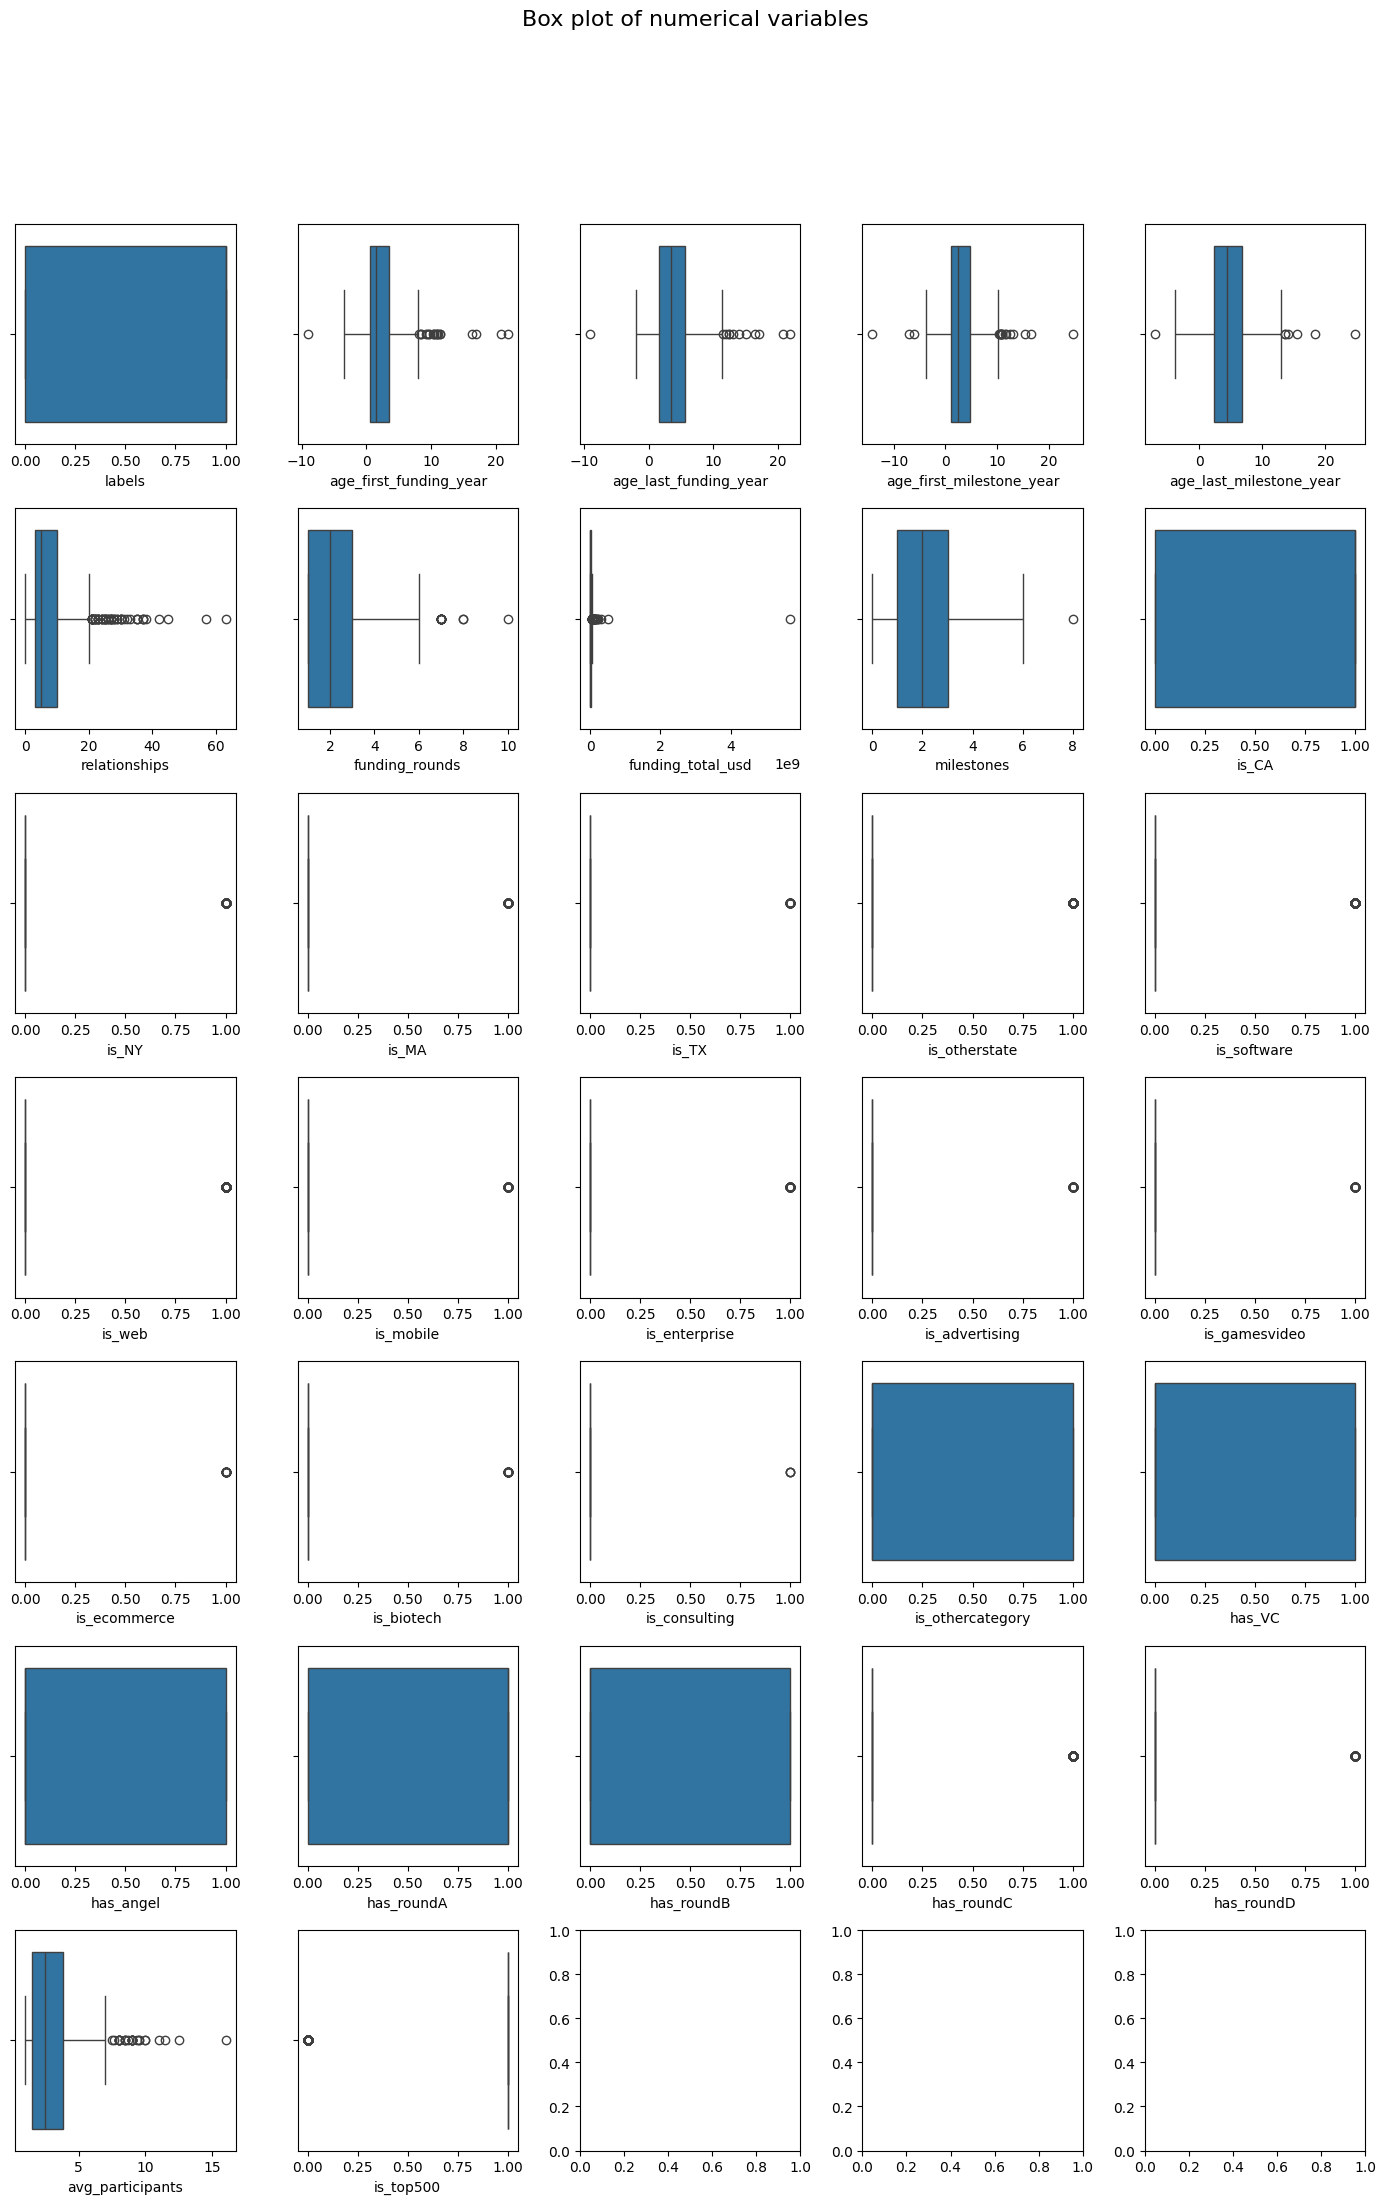

In [12]:
#Box plot of Numerical features to examine the distribution of the features
drop_columns = ['Unnamed: 0', 'latitude', 'longitude']  # Columns to drop
try:
  df = df.drop(columns=drop_columns, axis=1)
except KeyError:
  print("Columns to drop do not exist in the DataFrame.")
num_column_lst = []
for icol in df.columns:
    if df[icol].dtypes in ['float64', 'int64']:
        num_column_lst.append(icol)
print(num_column_lst)

fig, axs = plt.subplots(nrows = 7, ncols=5, figsize = (14,20))
for name,ax in zip(num_column_lst,axs.flatten()):
    sns.boxplot(data=df,x=name,ax=ax)
  # plt.show()
fig.tight_layout()
fig.suptitle('Box plot of numerical variables',y=1.1,fontsize=16)

Text(0.5, 1.05, 'Distribution Plot of Numerical Features')

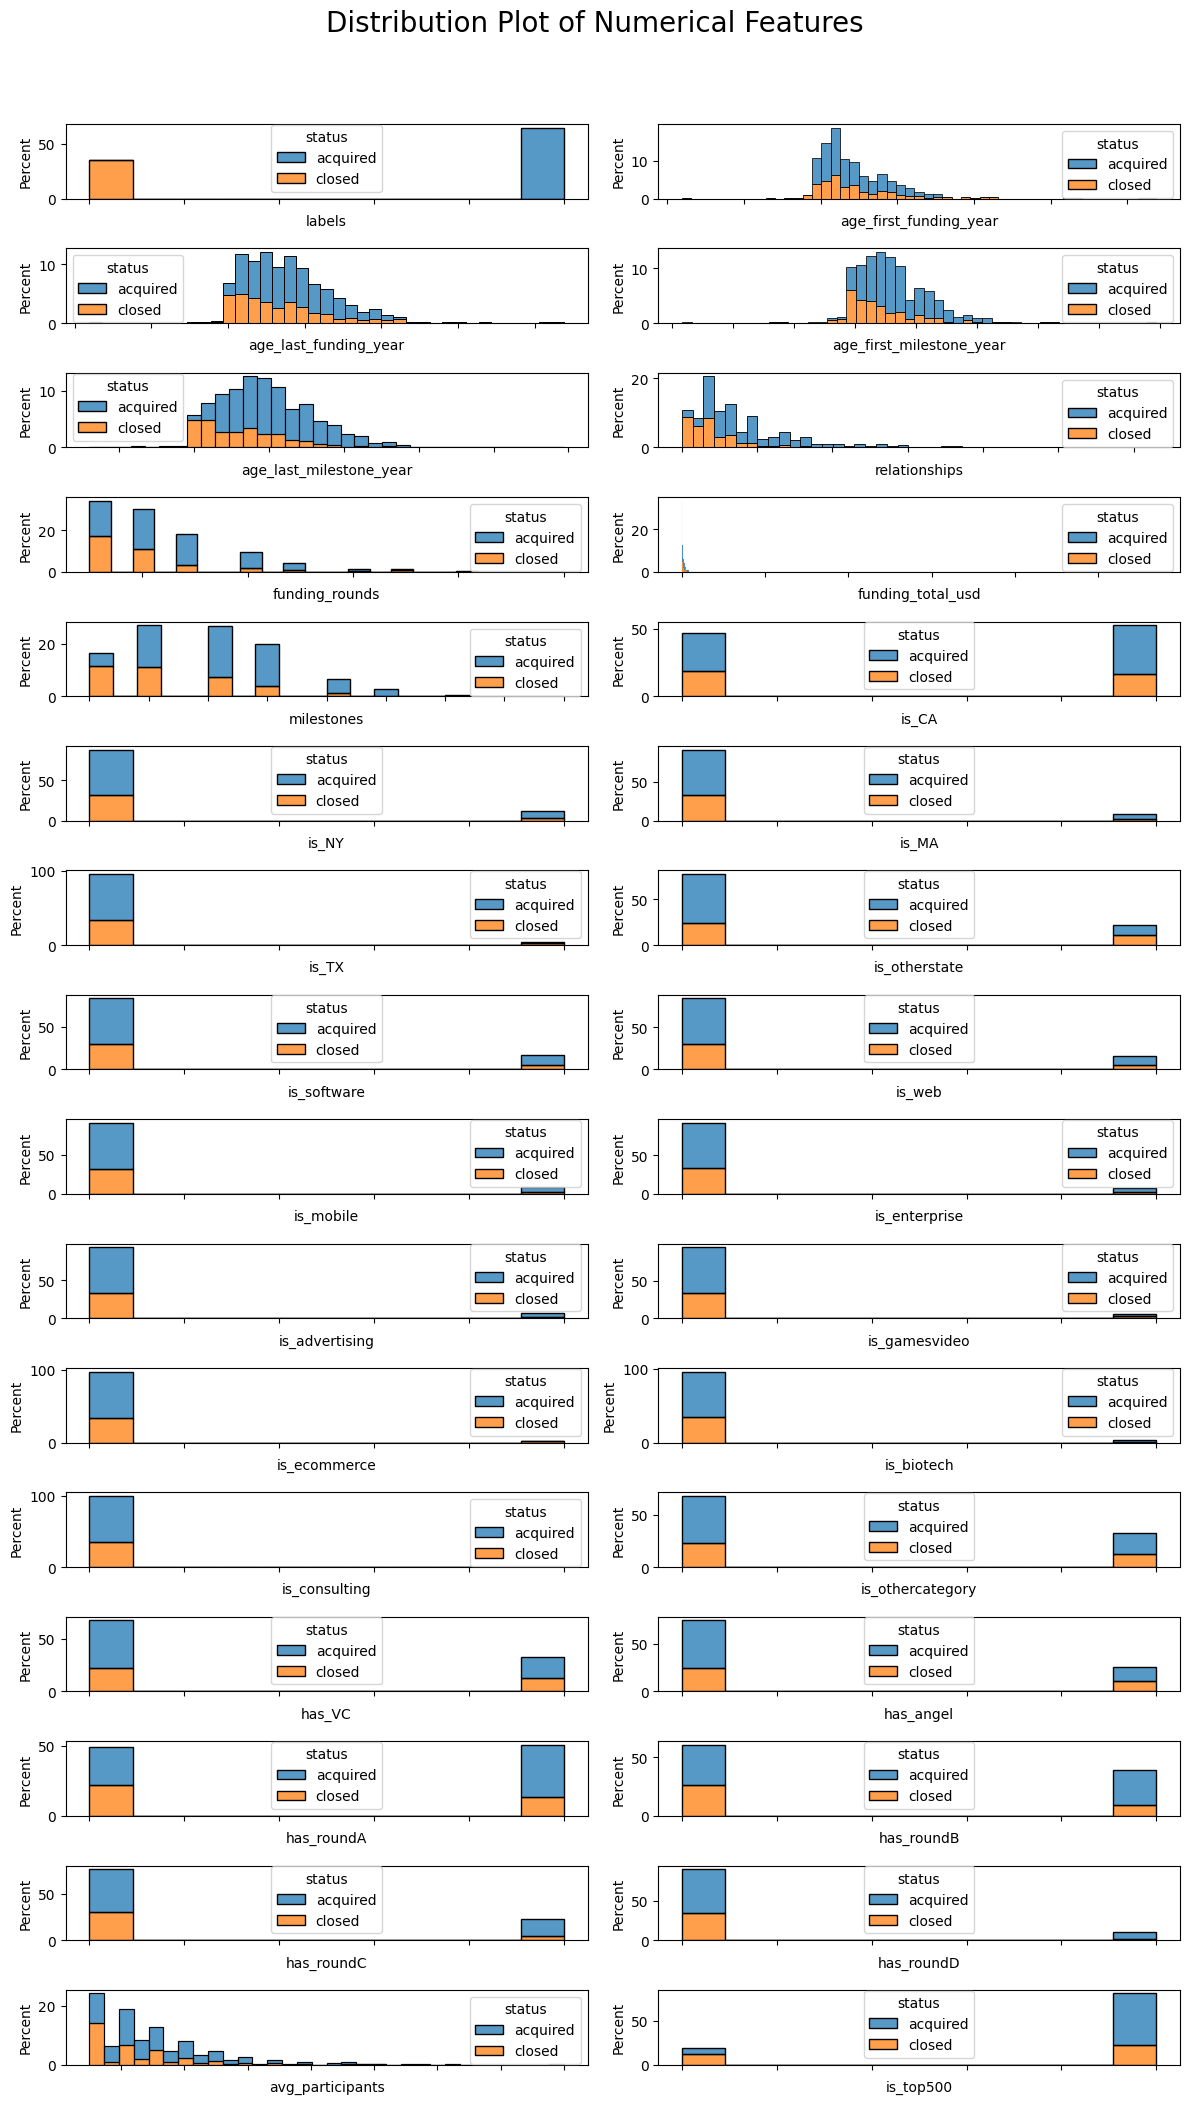

In [13]:
# Distribution Plot of the Numerical features 
fig, axs = plt.subplots(nrows = 16, ncols=2, figsize = (12,20))
for name,ax in zip(num_column_lst,axs.flatten()):
    sns.histplot(data=df,x=name,ax=ax,hue='status',multiple='stack',stat='percent')
    ax.set_xticklabels(ax.get_xticklabels(minor=True,which='minor'),rotation=0,fontsize=50)

fig.tight_layout()
fig.suptitle('Distribution Plot of Numerical Features',y=1.05,fontsize=20)


Text(0.5, 1.0, 'Correlation Matrix of the numerical features')

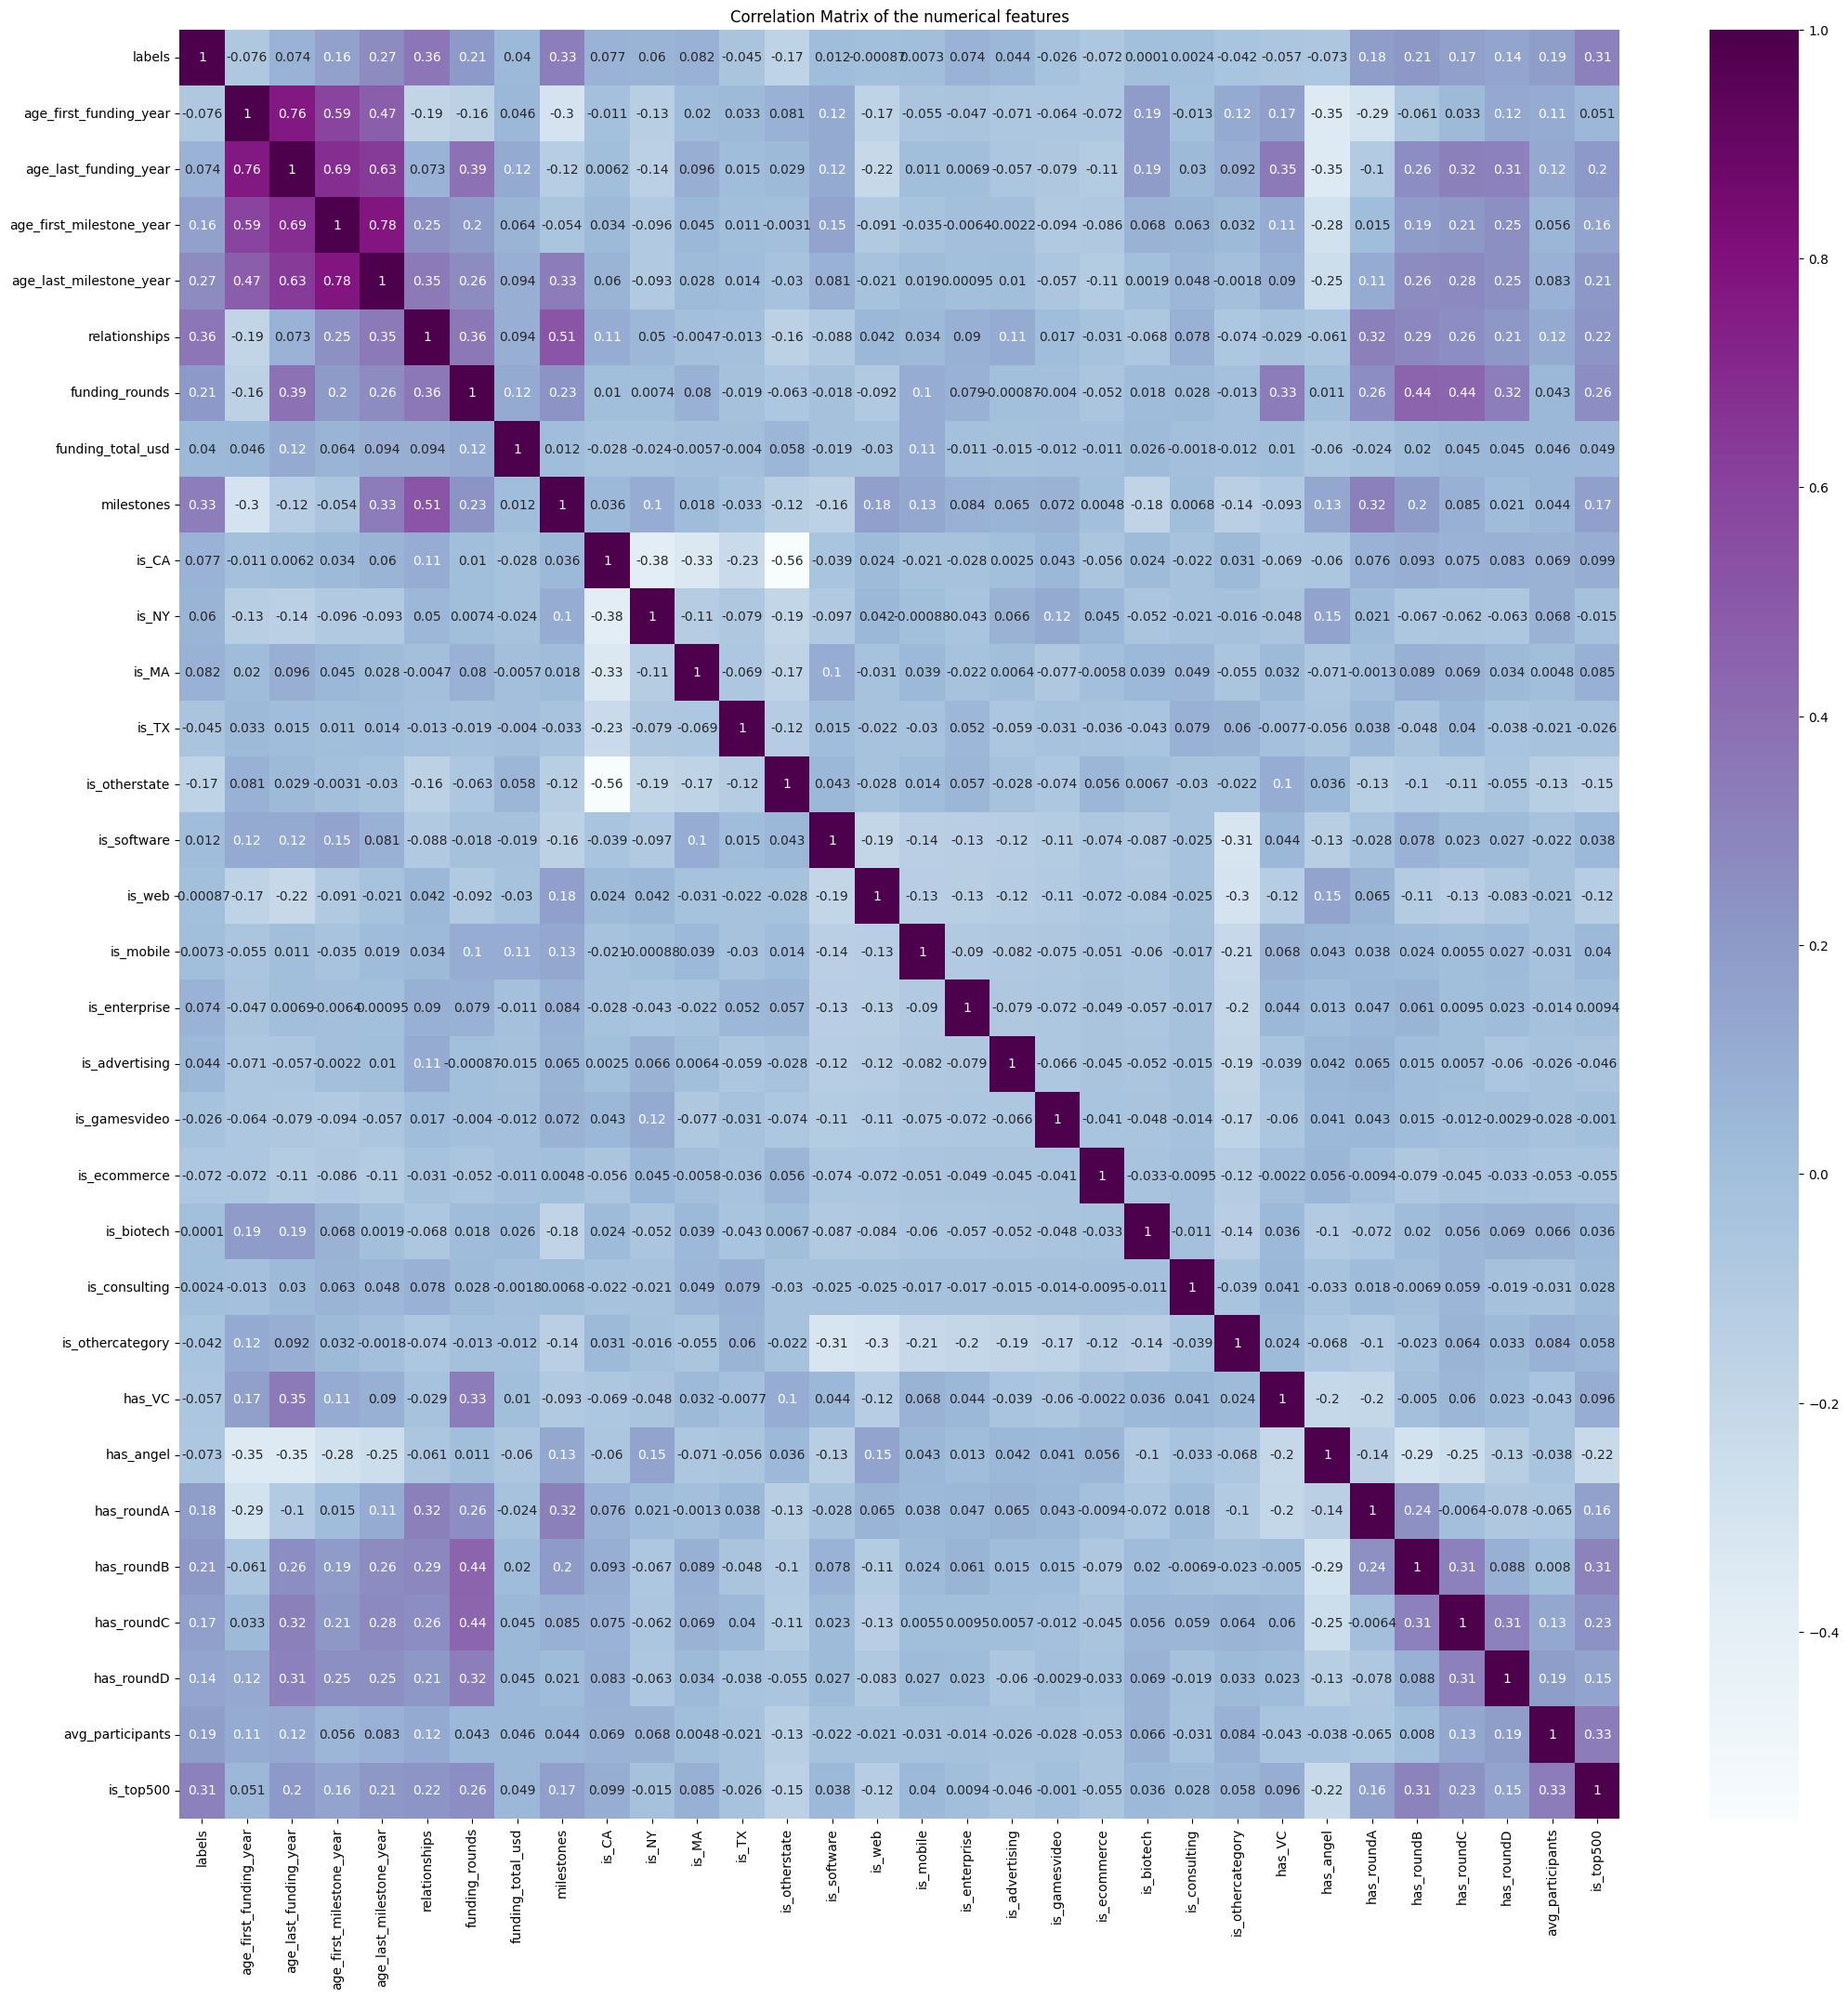

In [14]:


plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='BuPu')
plt.title('Correlation Matrix of the numerical features')




## Exploratory Data Analysis (EDA)

### Step 1: Data Cleaning

* Identify and address missing values:

    - Example: Unnamed: 6 (50% missing), closed_at, and age_first_milestone_year have missing entries. These need imputation or exclusion depending on their relevance.

    - Verify and clean categorical data: Standardize values in columns like state_code, category_code.

    - Remove or address duplicates and redundant columns: Example: Unnamed: 0 and state_code.1 are potentially redundant.



In [15]:
# Create a new category column since most features are have a large number unique values
new_cat_column_lst = ['state_code', 'state_code.1', 'category_code', 'status']

Text(0.5, 1.05, 'Distribution of Categorical variables')

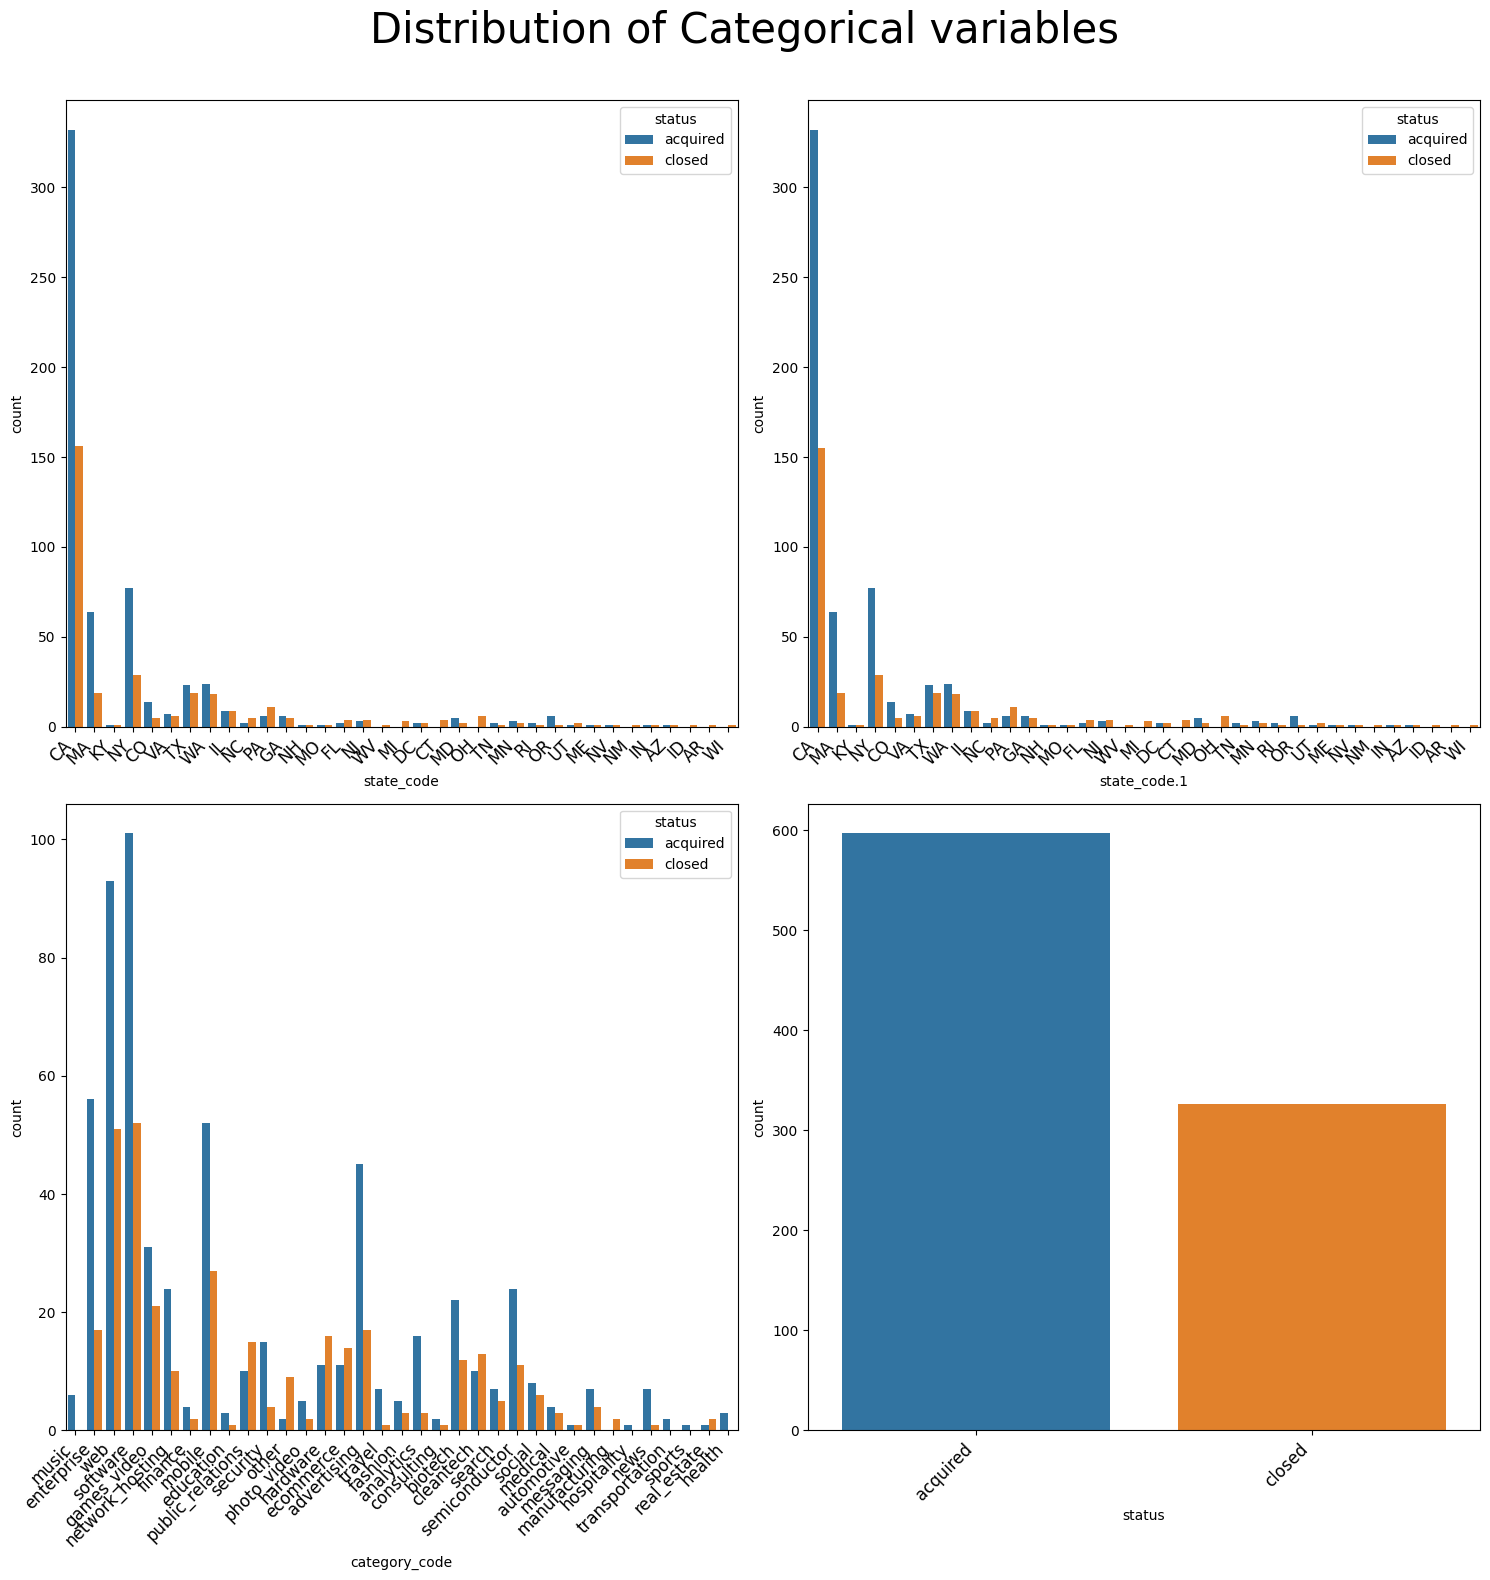

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize = (15,15))
for name,ax in zip(new_cat_column_lst,axs.flatten()):
    sns.countplot(data=df,x=name,ax=ax,hue='status')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)

fig.tight_layout()
fig.suptitle('Distribution of Categorical variables',y=1.05,fontsize=30)

In [18]:
df_clean = df.drop([ 'zip_code', 'id', 'Unnamed: 6', 'name', 'object_id',
                             'state_code', 'city', 'state_code.1', 'founded_at', 'first_funding_at', 
                             'last_funding_at', 'closed_at', 'category_code', 'status'], axis = 1)

df_clean[df_clean.isna().any(axis=1)].head()

,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
12,0,4.9041,4.9041,NaN,NaN,0,1,350000,0,0,...,0,0,1,0,0,0,0,0,1.0,0
15,0,6.6082,6.6082,NaN,NaN,0,1,200000,0,0,...,0,1,1,0,0,0,0,0,1.0,0
24,0,0.2521,0.3370,NaN,NaN,5,2,455000,0,0,...,0,1,0,1,1,0,0,0,4.5,1
32,0,-0.1671,2.0192,NaN,NaN,9,2,5000000,0,0,...,0,0,0,0,1,1,0,0,2.5,1
34,0,0.0822,0.0822,NaN,NaN,2,1,25000,0,0,...,0,1,0,1,0,0,0,0,1.0,0


In [19]:
#Replace the NaN with 0
df_clean['age_first_milestone_year'] = df_clean['age_first_milestone_year'].fillna(0)
df_clean['age_last_milestone_year'] = df_clean['age_last_milestone_year'].fillna(0)

#Feature engineer the 'age_first_milestone_year' & 'age_last_milestone_year' into 'time_to_accomplish_milestones'
df_clean['time_to_accomplish_milestones'] = df_clean['age_last_milestone_year'] - df_clean['age_first_milestone_year']

#Now drop the two columns 'age_first_milestone_year' & 'age_last_milestone_year' 
df_feat_eng1 = df_clean.drop(['age_first_milestone_year', 'age_last_milestone_year'], axis = 1)
df_feat_eng1.head()

,labels,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,time_to_accomplish_milestones
0,1,2.2493,3.0027,3,3,375000,3,1,0,0,...,1,0,1,0,0,0,0,1.0000,0,2.0356
1,1,5.1260,9.9973,9,4,40100000,1,1,0,0,...,0,1,0,0,1,1,1,4.7500,1,0.0000
2,1,1.0329,1.0329,5,1,2600000,2,1,0,0,...,0,0,0,1,0,0,0,4.0000,1,0.7480
3,1,3.1315,5.3151,5,3,40000000,1,1,0,0,...,0,0,0,0,1,1,1,3.3333,1,0.0000
4,0,0.0000,1.6685,2,2,1300000,1,1,0,0,...,0,1,1,0,0,0,0,1.0000,1,0.0000


In [20]:
corr_matrix = df_feat_eng1.corr()
print(corr_matrix["time_to_accomplish_milestones"].sort_values(ascending=False))

time_to_accomplish_milestones    1.000000
milestones                       0.637713
relationships                    0.247335
labels                           0.245475
has_roundA                       0.183103
has_roundB                       0.142388
funding_rounds                   0.140946
is_web                           0.123645
is_top500                        0.116136
has_roundC                       0.107872
is_mobile                        0.094988
is_gamesvideo                    0.056937
funding_total_usd                0.054274
is_CA                            0.050351
has_angel                        0.047872
avg_participants                 0.047083
is_enterprise                    0.037083
has_roundD                       0.031114
is_advertising                   0.021278
is_NY                            0.010258
is_MA                           -0.001313
is_TX                           -0.008605
is_consulting                   -0.021532
has_VC                          -0



### Step 2: Summary Statistics

* Generate descriptive statistics to understand central tendencies and distributions for numeric variables (funding_total_usd, relationships, etc.).

* Analyze categorical variable distributions (e.g., category_code).


time_to_full_funding             1.000000
funding_rounds                   0.793134
has_roundB                       0.475302
has_roundC                       0.443267
relationships                    0.355481
has_roundD                       0.321391
has_VC                           0.320036
is_top500                        0.241988
has_roundA                       0.227045
labels                           0.211053
milestones                       0.195224
time_to_accomplish_milestones    0.153269
is_MA                            0.121338
funding_total_usd                0.118263
is_mobile                        0.087540
is_enterprise                    0.071906
is_consulting                    0.061866
is_biotech                       0.043712
avg_participants                 0.040088
is_software                      0.027395
is_CA                            0.023487
is_advertising                   0.005370
is_othercategory                -0.009050
is_TX                           -0

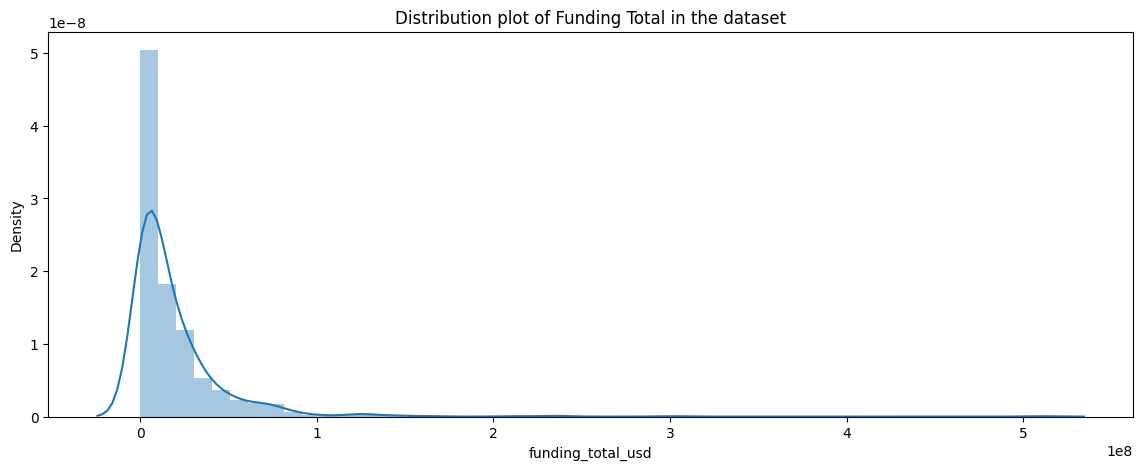

In [22]:
#Feature engineer the 'age_last_funding_year' & 'age_first_funding_year' into 'time_to_full_funding'
df_feat_eng1['time_to_full_funding'] = df_feat_eng1['age_last_funding_year'] - df_feat_eng1['age_first_funding_year']
#Now drop the two columns 'age_first_funding_year' & 'age_last_funding_year' 
df_feat_eng2 = df_feat_eng1.drop(['age_first_funding_year', 'age_last_funding_year'], axis = 1)
df_feat_eng2.head()
corr_matrix = df_feat_eng2.corr()
print(corr_matrix["time_to_full_funding"].sort_values(ascending=False))

df_outl_corr = df_feat_eng2[(df_feat_eng2['funding_total_usd'] < 594322842.5584742) 
                            & (df_feat_eng2['funding_total_usd'] > -543483344.3742923)]



#Distribution plot of the funding_total_usd feature 
plt.figure(figsize=(14,5))
sns.distplot(df_outl_corr['funding_total_usd']).set(title = 'Distribution plot of Funding Total in the dataset')
plt.show()


### Step 3: Data Distributions

* Plot histograms for numeric variables:

    - Funding (funding_total_usd)

        Age of the startup (age_first_funding_year, age_last_milestone_year)

    - Bar charts for categorical variables:

        Sector (is_biotech, is_ecommerce)

        State (is_CA, is_NY)

### Step 4: Correlation Analysis

* Calculate and visualize correlations between numeric variables:

    - Example: Use a heatmap to identify relationships between funding_rounds, relationships, funding_total_usd.

    - Analyze the relationship between key variables and success labels.

* Step 5: Feature Exploration

    - Investigate the importance of specific features like:

        Geographical impact (is_CA, latitude, longitude).

        Investor presence (has_VC, has_angel).

        Industry indicators (is_biotech, is_ecommerce).

* Step 6: Visualizations

    - Create meaningful visualizations to enhance understanding:

        - Pie charts for sector distribution (is_biotech, is_ecommerce).

        - Box plots comparing funding totals across startup categories.

        - Time-series analysis of startup founding dates (founded_at, closed_at).

        - Scatter plots for relationships vs. funding (relationships and funding_total_usd).

* Step 7: Imbalanced Dataset Handling

    - Inspect the imbalance in success labels (labels and status).

    - Use oversampling or undersampling methods if necessary during modeling.



### Preliminary Findings

* Funding Trends:

    - Distribution of funding across categories.

    - Role of successive funding rounds (A, B, C, D) in startup success.

* Sector Performance:

    - is_biotech and is_ecommerce are prominent categories.

    - Impact of sector choice on startup outcomes.

* Location Factors:

    - Analyze whether startups in California or New York have higher success rates.

* Relationships:

    - Examine the impact of the relationships variable on acquisition likelihood.

### Next Steps

* Complete cleaning and preprocessing of the dataset.

* Deepen feature engineering for poorly described columns.

* Use insights from EDA to select features for predictive modeling.

* Explore advanced visualizations for more nuanced relationships.
